In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, fixed


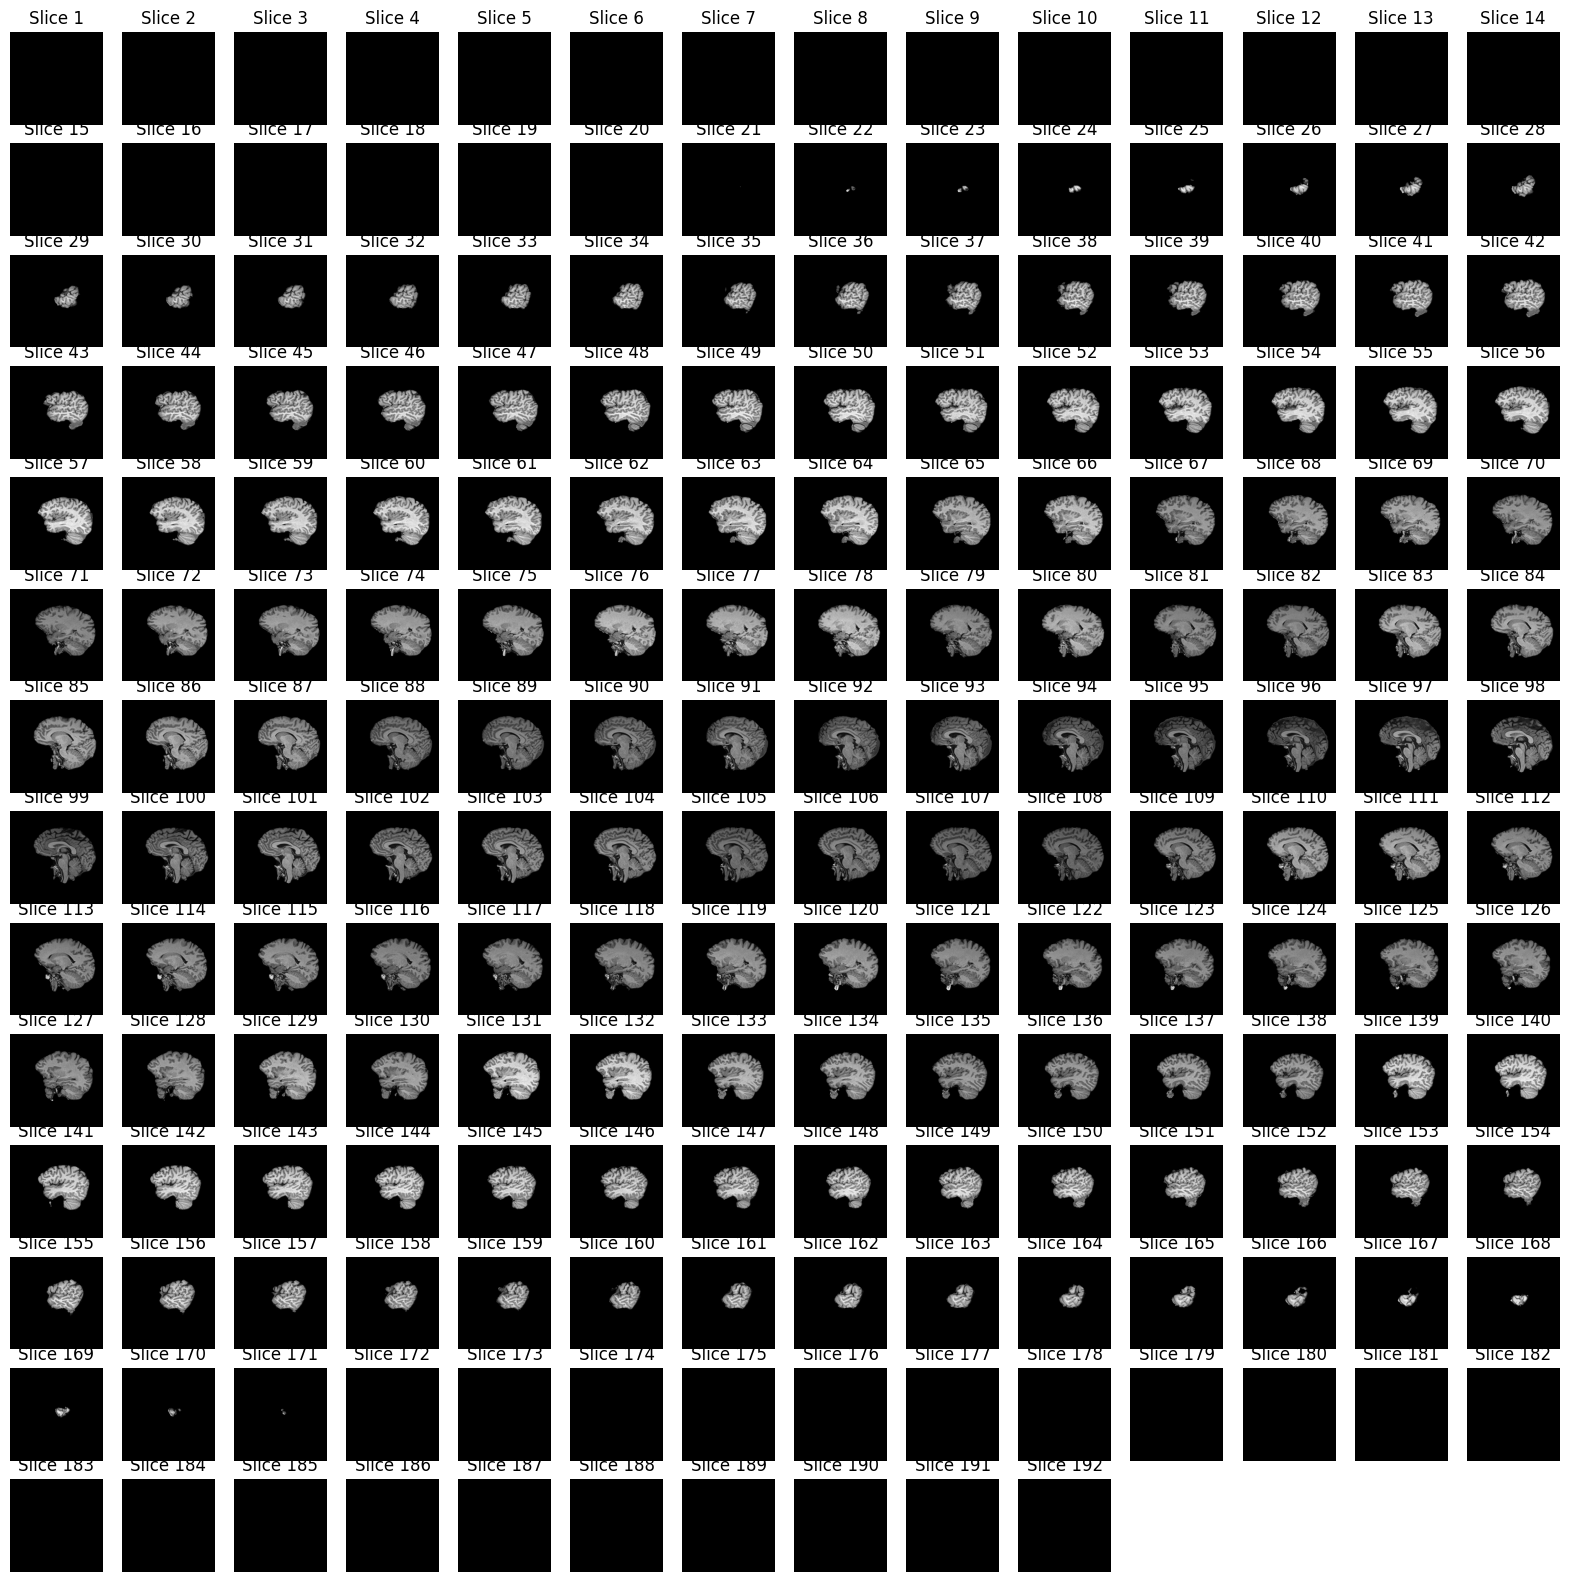

In [2]:
nifti_file = 'nifti/output_brain.nii.gz'
def visualize_nifti_grid(nifti_file):
    nifti_img = nib.load(nifti_file)
    nifti_data = nifti_img.get_fdata()
    num_slices = nifti_data.shape[2]
    
    cols = int(np.ceil(np.sqrt(num_slices)))
    rows = int(np.ceil(num_slices / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    
    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        if i < num_slices:
            ax.imshow(nifti_data[:, :, i], cmap='gray')
            ax.set_title(f'Slice {i+1}')
        ax.axis('off')
    
    plt.show()

# Visualizar en cuadrícula
visualize_nifti_grid(nifti_file)


In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, fixed


def load_nifti_data(nifti_file):
    """Carga el archivo NIfTI y devuelve los datos y la affine."""
    img = nib.load(nifti_file)
    data = img.get_fdata()
    return data, img.affine

def plot_slices(original_data, stripped_data, slice_idx):
    """Visualiza un corte específico de los volúmenes original y procesado."""
    plt.figure(figsize=(12, 6))
    
    # Visualizar el corte del volumen original
    plt.subplot(1, 2, 1)
    plt.imshow(original_data[:, :, slice_idx], cmap='gray')
    plt.title(f'Original - Slice {slice_idx}')
    plt.axis('off')
    
    # Visualizar el corte del volumen procesado
    plt.subplot(1, 2, 2)
    plt.imshow(stripped_data[:, :, slice_idx], cmap='gray')
    plt.title(f'Skull Stripped - Slice {slice_idx}')
    plt.axis('off')
    
    plt.show()

def visualize_nifti_comparison(original_nifti_file, stripped_nifti_file):
    """Función principal para cargar y comparar los NIfTI."""
    original_data, _ = load_nifti_data(original_nifti_file)
    stripped_data, _ = load_nifti_data(stripped_nifti_file)
    
    # Asegurarse de que ambas imágenes tienen el mismo número de slices
    assert original_data.shape == stripped_data.shape, "Los volúmenes deben tener las mismas dimensiones"
    
    # Configurar el slider
    slices = original_data.shape[2]
    interact(plot_slices, 
             original_data=fixed(original_data), 
             stripped_data=fixed(stripped_data), 
             slice_idx=IntSlider(min=0, max=slices-1, step=1, value=slices//2))

# Rutas de los archivos NIfTI
original_nifti_file = 'nifti/series_1.3.12.2.1107.5.2.53.190483.30000024080708183568100000011.nii'
stripped_nifti_file = 'nifti/output_brain.nii.gz'

# Ejecutar la visualización
visualize_nifti_comparison(original_nifti_file, stripped_nifti_file)


interactive(children=(IntSlider(value=96, description='slice_idx', max=191), Output()), _dom_classes=('widget-…

In [10]:
import os
import pydicom
import subprocess
import nibabel as nib
def is_dicom_file(file_path):
    try:
        pydicom.dcmread(file_path, stop_before_pixels=True)
        return True
    except pydicom.errors.InvalidDicomError:
        return False

def sort_dicoms_by_series(dicom_dir):
    series_dict = {}
    for root, _, files in os.walk(dicom_dir):
        for file in files:
            dicom_path = os.path.join(root, file)
            if is_dicom_file(dicom_path):
                ds = pydicom.dcmread(dicom_path)
                series_number = ds.SeriesNumber
                if series_number not in series_dict:
                    series_dict[series_number] = []
                series_dict[series_number].append(dicom_path)
    return series_dict

def convert_dicoms_to_nifti(series_dict, output_dir):
    nifti_files = []
    dcm2niix_path = "C:/Users/lcres/PycharmProjects/Software/Archivos_Dicom/dcm2niix.exe"  # Ruta completa al ejecutable
    for series_number, dicoms in series_dict.items():
        series_output_dir = os.path.join(output_dir, f"series_{series_number}")
        os.makedirs(series_output_dir, exist_ok=True)
        dicom_input_dir = os.path.join(series_output_dir, "dicoms")
        os.makedirs(dicom_input_dir, exist_ok=True)
        for dicom in dicoms:
            os.rename(dicom, os.path.join(dicom_input_dir, os.path.basename(dicom)))
        
        nifti_output_path = os.path.join(series_output_dir, f"series_{series_number}.nii")
        subprocess.run([dcm2niix_path, "-z", "y", "-f", "series_%s" % series_number, "-o", series_output_dir, dicom_input_dir])
        nifti_files.append(nifti_output_path)
    return nifti_files

def apply_bet_to_nifti(nifti_files):
    bet_output_files = []
    for nifti_file in nifti_files:
        bet_output_file = nifti_file.replace(".nii", "_brain.nii")
        subprocess.run(["bet", nifti_file, bet_output_file, "-f", "0.5", "-g", "0"])
        bet_output_files.append(bet_output_file)
    return bet_output_files

def process_patients(base_dir, output_dir):
    for patient_dir in os.listdir(base_dir):
        patient_path = os.path.join(base_dir, patient_dir)
        if os.path.isdir(patient_path):
            print(f"Processing patient: {patient_dir}")
            series_dict = sort_dicoms_by_series(patient_path)
            nifti_files = convert_dicoms_to_nifti(series_dict, output_dir)
            bet_output_files = apply_bet_to_nifti(nifti_files)
            print(f"Finished processing patient: {patient_dir}")

# Usar las rutas adecuadas
base_patient_dir = "C:/Users/lcres/PycharmProjects/Software/Archivos_Dicom"
output_dir = "C:/Users/lcres/PycharmProjects/Software/nifti/plataforma"
process_patients(base_patient_dir, output_dir)


Processing patient: 18380000


FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado